In [177]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from tqdm import tqdm
import os
import pandas as pd

class Record:
    def __init__(self, T_0, notes_to_choose = 5):
        self.notes_to_choose = notes_to_choose
        self.transitions = [T_0]
        self.trajectories = []
        
    def give_transition_matrix(self,melody):
        lookup = np.empty((5))
        lookup[[0,1,2,3,4]] = np.arange(5)
        counts = np.zeros((5,5))
        np.add.at(counts, (melody[:-1], melody[1:]),1 )
        probs = counts/counts.sum(axis=0, keepdims=True)
        self.transitions.append(probs)
        return probs
    

class Evaluator():
    def __init__(self):
        self.reward_history = []
        self.trajectories = []
    def give_reward(self, guess, label):
        if guess == label:
            return 1
        else:
            return 0
        
class Agent():
    def __init__(self, notes_to_choose, gamma=0., ep=0.01):
        self.n_actions = notes_to_choose
        self.states = notes_to_choose
        self.q = np.zeros((notes_to_choose, notes_to_choose))
        self.n = np.zeros((notes_to_choose, notes_to_choose))
        
        self.epsilon = ep
        self.gamma = gamma
        
    def give_action(self, state):
        if np.random.random()<self.epsilon:
            return np.random.choice(range(self.n_actions), 1)[0]
        else:
            qs = self.q[:,state]
            qs = np.where( qs == np.max(qs) )[0]
            #if len(qs)>0:
            return np.random.choice(qs, 1)[0]
            #else:
            #    return qs
            

    def q_learn(self, ts):
        ### q-learn
        for interaction in ts:
            s, a, r, ns = interaction
            if ns != -1:
                self.n[s,a]+=1
                self.q[s,a] += (r+ agent.gamma*np.max(self.q[ns,:]))/self.n[s,a]
            else:
                self.n[s,a]+=1
                self.q[s,a] += r/self.n[s,a]
                
    def decrease_ep(self,ind):
        self.epsilon = max(self.epsilon*np.exp(-(ind+1)/100), 0.01)
        return

100%|██████████| 100/100 [00:00<00:00, 2696.04it/s]


Text(0, 0.5, 'Cumulative reward ($\\frac{Success}{TOTAL}$)')

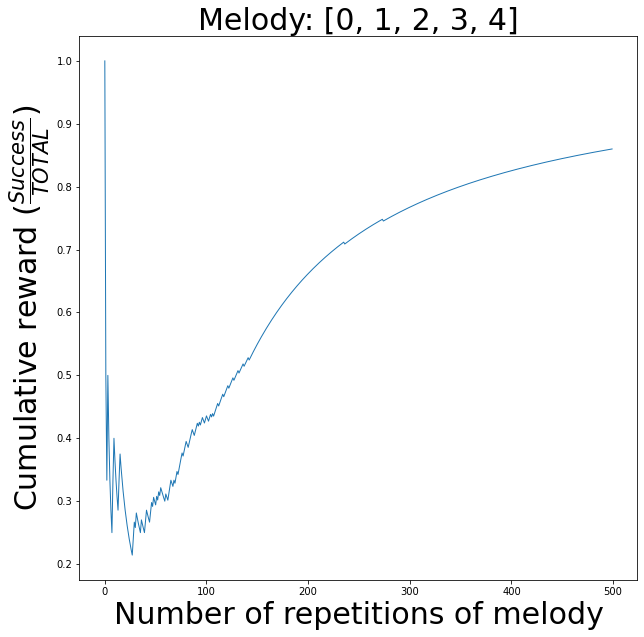

In [181]:
evaluator = Evaluator()
agent = Agent(5, gamma=0., ep=1)
melody = [0,1,2,3,4]


for episode in tqdm(range(100)):
    state = 0
    ts=[]
    actions=[]
    for ind,note in enumerate(melody):
        state = note
        action = agent.give_action(state)
        actions.append(action)
        reward = evaluator.give_reward(action,state)
        evaluator.reward_history.append(reward)
        if ind!=len(melody)-1:
            next_state = action
        else:
            next_state = -1
        ts.append([state, action, reward, next_state])
    agent.q_learn(ts)
    agent.decrease_ep(episode)
    evaluator.trajectories.append(actions)

plt.figure(figsize=(10,10))
plt.title("Melody: {}".format(melody),size=30)
plt.plot(np.cumsum(evaluator.reward_history)/np.arange(1,len(evaluator.reward_history)+1), linewidth=1)
plt.xlabel("Number of repetitions of melody",size=30)
plt.ylabel("Cumulative reward ("+r'$\frac{Success}{TOTAL}$'+")",size=30)

0

In [ ]:
os.makedirs("rl_trajs", exist_ok=True)
os.system("rm -r rl_trajs/*")

for ind,p in enumerate(evaluator.trajectories):
    dictionary={"notas1":[66,64,60,70,62], "weight":p}
    dd = pd.DataFrame.from_dict(dictionary, orient="index")
    dd.to_csv("rl_trajs"+"/episode_{}".format(ind), header=False)